# A. Introduction

I conducted basic exploratory data analysis to explore patterns and correlations between an MLB batter's performance metrics and his salary, dating from 1985. I plan to use these insights gained from the following rudimentary data exploration for other personal projects such as using machine learning to determine whether a team is undervaluing or overvaluing a player, understanding player performance regression, as well as predicting the number of team wins given historical stats of players in the team.  

This project uses data from Sean Lahman's Baseball Database. The URL of the source of the data is http://www.seanlahman.com/baseball-archive/statistics/.
This work is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License. For details see: http://creativecommons.org/licenses/by-sa/3.0/

Lahman's baseball database has 24 different csv tables. I've chosen three of them for this analysis: "Batting.csv", "BattingPost.csv", and "Salaries.csv". 

- **Batting.csv**: Each instance contains information about a player's performance metrics in a given season as well as the team and the league he played in. The `playerID` key represents a player and the year he played in. When a player is traded to a different team within a given year, the statistics are treated separate and recorded in separate rows of the dataframe. The number of these duplicates are indicated by the feature `stint`, representing the number of "stints" a player has had in a given season. The dataset contains information from 1871 to 2020. 

    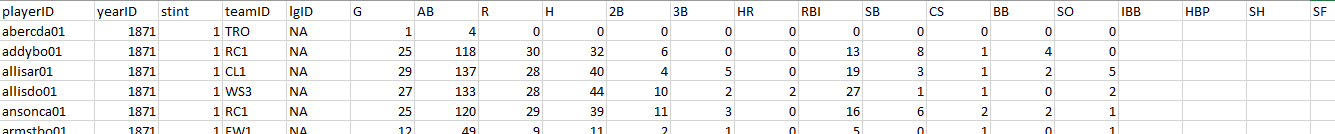
    
    <br>

- **BattingPost.csv**: This contains mostly the same information as Batting.csv, using the same `playerID` key. But for the postseason. Each instance represents a player's performance metric in a given year in a given round of the playoffs (e.g. World Series). The rounds are indicated by the feature `round`, which effectively replaces `round` from Batting.csv. The dataset contains information from 1884 to 2020. 

    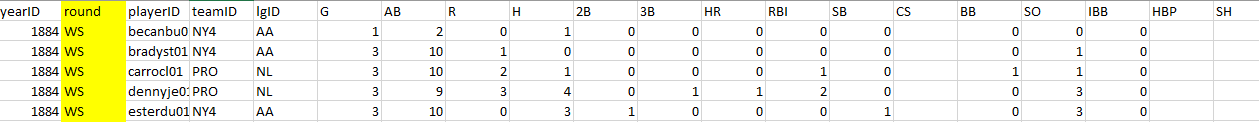


- **Salaries.csv**: This also uses the same `playerID` key, with each instance containing how much salary a player has earned in that given year (in USD). This dataset contains information from 1985 to 2020. 

    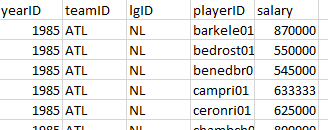


In the initial exploration stage, I attempted to confirm patterns and trends based on knowledge I have about baseball statistics. Then, via EDA, I attempted to identify the greatest determinant of a team making it into the postseason. I hypothesized that the total cumulative runs of a team in a given season would be a good predictor of the team making it to the postseason.

<br>

# B. Setting up/Data Merging 


In [35]:

options(warn=-1)

options(repr.matrix.max.cols=40, repr.matrix.max.rows=20)
# library(UsingR, quietly = TRUE, warn.conflicts = FALSE)
library(tidyverse)
batting = read_csv("data/Batting.csv", col_types = cols())
batting_post = read_csv("data/BattingPost.csv", col_types = cols())
salaries = read_csv("data/Salaries.csv", col_types = cols())
# batting$IBB = as.numeric(batting$IBB)
# batting$HBP = as.numeric(batting$HBP)
# batting$SH = as.numeric(batting$SH)
# batting$SF = as.numeric(batting$SF)




In [36]:

# install.packages("dplyr", repos = "http://cran.us.r-project.org")

# packageVersion("dplyr")


To make them easier to analyze, I cut out all data from before 1985 to make data easier to handle, and also to ensure that most data had salary information as salary information is only available from 1985. To distinguish stats from regular season and Postseason, I added an indicator variable saying whether the statistic was from a regular season or Postseason. I created a new identifier variable that identifies a statistic for a player in a specific year for a specific team, for all three tables, and merged the three .csv files into one. I added new variables `BA` (Batting average) and `Kperc` (Strikeout percentage) which can be calculated from the given information, and I also added a new variable `postseason_app` (postseason appearance) indicating whether a team that the player played for that season ended up making it to the playoffs or not.

I attempted to merge these three datasets and engineer some features by taking the following steps.

* Cut out all data from before 1985 to make data easier to handle, and also to ensure that most data had salary information as salary information is only available from 1985. 
* To distinguish stats from regular season and Postseason, added a binary indicator variable `postseason` saying whether the statistic was from a regular season or Postseason.
* Created a new identifier variable that identifies a statistic for a player in a specific year for a specific team, for all three tables
* Merged the three datasets into one
* Added new variables `BA` (Batting average) and `Kperc` (Strikeout percentage) which can be calculated from the given information. 
* Added a new variable `postseason_app` (postseason appearance) indicating whether a team that the player played for that season ended up making it to the playoffs or not.

<br> 

These steps are outlined in the next section.

<br>


In [37]:
# Applying filters to select only batting data from 1985
batting <- filter(batting, yearID >= 1985)
batting_post <- filter(batting_post, yearID >= 1985)
# Creating new ID key for each player and the year/team they played in
merged_batting <- bind_rows(batting, batting_post) %>% 
  unite('playerseasonID', c("yearID", "playerID", "teamID"), remove = FALSE) %>%
  mutate(
    postseason = if_else(is.na(round), 0, 1) #postseason indicator
  ) 

# Postseason appearance indicator
merged_batting_postseason_app <- merged_batting %>% group_by(playerseasonID) %>%
  summarise(postseason_app = max(postseason)) %>%
  inner_join(merged_batting, by = "playerseasonID") %>%
  mutate(postseason = if_else(postseason == 1, 'Y', 'N')) %>%
  mutate(postseason_app = if_else(postseason_app == 1, 'Y', 'N'))

# Merging with Salary Data and adding new metrics
df <- salaries %>%
  unite('playerseasonID', c("yearID", "playerID", "teamID"), remove = FALSE) %>%
  dplyr::select('playerseasonID', 'salary') %>%
  right_join(merged_batting_postseason_app, by = "playerseasonID") %>% 
  mutate(BA = H/AB) %>% # batting average 
  mutate(Kperc = SO/AB) %>% # strikeout percentage
  # reordering columns 
  relocate(salary, .after = last_col()) %>%
  relocate(c(playerseasonID, playerID, yearID, teamID, stint, lgID)) %>%
  relocate(c(postseason, postseason_app, round), .after = lgID) %>%
  relocate(c(BA, Kperc), .after = AB)

head(df)

playerseasonID,playerID,yearID,teamID,stint,lgID,postseason,postseason_app,round,G,AB,BA,Kperc,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
1985_barkele01_ATL,barkele01,1985,ATL,1,NL,N,N,NA,20,17,0.0000000,0.41176471,0,0,0,0,0,0,0,1,0,7,0,0,0,0,0,870000
1985_bedrost01_ATL,bedrost01,1985,ATL,1,NL,N,N,NA,37,64,0.0781250,0.34375000,3,5,0,0,0,1,0,0,1,22,0,0,NA,0,0,550000
1985_benedbr01_ATL,benedbr01,1985,ATL,1,NL,N,N,NA,70,208,0.2019231,0.05769231,12,42,6,0,0,20,0,1,22,12,1,1,NA,NA,8,545000
1985_campri01_ATL,campri01,1985,ATL,1,NL,N,N,NA,66,13,0.2307692,0.38461538,1,3,0,0,1,2,0,0,1,5,0,0,1,0,0,633333
1985_ceronri01_ATL,ceronri01,1985,ATL,1,NL,N,N,NA,96,282,0.2163121,0.08865248,15,61,9,0,3,25,0,3,29,25,1,1,0,NA,15,625000
1985_chambch01_ATL,chambch01,1985,ATL,1,NL,N,N,NA,101,170,0.2352941,0.12941176,16,40,7,0,3,21,0,0,18,22,NA,0,0,1,5,800000


[1] "double"